# Example of $R$ and $\theta^*$ selection

In [43]:
import bilby
import numpy as np

np.random.seed(42)

label = 'gaussian_example'
outdir = 'outdir_gaussian_example'

import numpy as np
import shutil
import os
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

import bilby


# set 2D multivariate Gaussian likelihood
class MultiGaussian(bilby.Likelihood):
    def __init__(self, mean, cov):
        super(MultiGaussian, self).__init__(parameters=dict())
        self.cov = np.array(cov)
        self.mean = np.array(mean)
        self.sigma = np.sqrt(np.diag(self.cov))
        self.pdf = multivariate_normal(mean=self.mean, cov=self.cov)

    @property
    def dim(self):
        return len(self.cov[0])

    def log_likelihood(self):
        x = np.array([self.parameters["x{0}".format(i)] for i in range(self.dim)])
        return self.pdf.logpdf(x)


np.random.seed(7)

# set 2D multivariate Gaussian (zero mean, unit variance)
mus = [0.0, 0.0]
cov = [[1.0, 0.0], [0.0, 1.0]]
dim = len(mus)
likelihood = MultiGaussian(mus, cov)

# set priors out to +/- 5 sigma
priors = bilby.core.prior.PriorDict()
priors.update(
    {
        "x{0}".format(i): bilby.core.prior.Uniform(-5, 5, "x{0}".format(i))
        for i in range(dim)
    }
)

# expected evidence integral should be (1/V) where V is the prior volume
log_prior_vol = np.sum(
    np.log(
        [prior.maximum - prior.minimum for key, prior in priors.items()]
    )
)
expected_ln_evidence = -log_prior_vol

grid_size = 100

result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=5000,
    walks=10, outdir=outdir, label=label, clean=False)


17:02 bilby INFO    : Running for label 'gaussian_example', output will be saved to 'outdir_gaussian_example'
/home/avaj040/.cache/pypoetry/virtualenvs/funnel-ZrW66eTN-py3.8/lib/python3.8/site-packages/bilby/core/utils/log.py:73: DeprecationWarning: Accessing attr.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for attrs's packaging metadata.
  vdict[key] = str(getattr(sys.modules[key], "__version__", "N/A"))
17:02 bilby INFO    : Analysis priors:
17:02 bilby INFO    : x0=Uniform(minimum=-5, maximum=5, name='x0', latex_label='x0', unit=None, boundary=None)
17:02 bilby INFO    : x1=Uniform(minimum=-5, maximum=5, name='x1', latex_label='x1', unit=None, boundary=None)
17:02 bilby INFO    : Analysis likelihood class: <class '__main__.MultiGaussian'>
17:02 bilby INFO    : Analysis likelihood noise evidence: nan
17:02 bilby INFO    : Single likelihood evaluation took 2.523e-05 s
17:02 bilby INFO    : Using sampler Dynesty with kwarg

1it [00:00, ?it/s]

17:03 bilby INFO    : Written checkpoint file outdir_gaussian_example/gaussian_example_resume.pickle
17:03 bilby INFO    : Rejection sampling nested samples to obtain 13690 posterior samples
17:03 bilby INFO    : Sampling time: 0:00:25.395743


17:03 bilby INFO    : Summary of results:
nsamples: 13690
ln_noise_evidence:    nan
ln_evidence: -4.646 +/-  0.028
ln_bayes_factor:    nan +/-  0.028



In [71]:
reference_params = [dict(x0=-0.2, x1=-0.2), dict(x0=-2.1, x1=-2.1)]
# compute the log likelihood at the reference points
reference_log_likelihoods = []
for reference_param in reference_params:
    likelihood.parameters.update(reference_param)
    reference_log_likelihoods.append(likelihood.log_likelihood())
reference_log_priors = [priors.ln_prob(s) for s in reference_params]

[-4.605170185988092, -4.605170185988092]

In [98]:
from funnel.fi_core import fi_ln_evidence

r_vals = np.geomspace(0.1, 5000, 5000)
# FI lnz for the reference points
post = result.posterior[["x0", "x1"]].values
ln_pri = result.posterior["log_prior"].values
ln_lnl = result.posterior["log_likelihood"].values

lnzs = np.zeros((len(reference_params), len(r_vals)))
for i, reference_param in enumerate(reference_params):
    p = [reference_param['x0'], reference_param['x1']]
    fi_kwargs = dict(
        posterior_samples=post,
        ref_samp=p,
        ref_lnpri=reference_log_priors[i],
        ref_lnl=reference_log_likelihoods[i],
    )
    lnzs[i] = np.array([fi_ln_evidence(**fi_kwargs, r=ri) for ri in r_vals])


<>:50: DeprecationWarning: invalid escape sequence \l
<>:50: DeprecationWarning: invalid escape sequence \l
/tmp/ipykernel_848372/1405741115.py:50: DeprecationWarning: invalid escape sequence \l
  ax2.axhline(expected_ln_evidence, color=posterior_color, linestyle='--', label='Analytical $\ln Z$', lw=3, zorder=1,


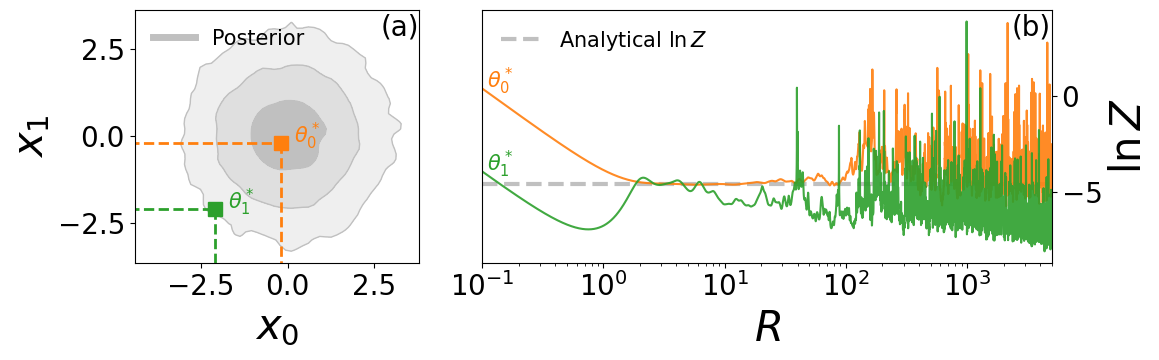

In [146]:
from corner.core import hist2d

# make fig with 2 axes, the left one is square, the right one is a rectangle 2 times wider (using gridspec)
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

posterior_color = 'silver'

hist2d(result.posterior.x0.values, result.posterior.x1.values, ax=ax1, bins=50, smooth=1.2, plot_datapoints=False,
       plot_density=False, plot_contours=True, fill_contours=True, color=posterior_color,
       contour_kwargs=dict(linewidths=1), data_kwargs=dict(alpha=0.5),
       levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)))

ax1.set_xlabel(r'$x_0$', fontdict={'fontsize': 30})
ax1.set_ylabel(r'$x_1$', fontdict={'fontsize': 30})
# make 3 ticks on each axis
ax1.locator_params(axis='both', nbins=3)
# make font size larger
plt.rcParams.update({'font.size': 20})

# overplot reference points in different colors and with different markers
for i, reference_param in enumerate(reference_params):
    lbl = r'$\theta^*_' + str(i) + '$'
    ax1.plot(reference_param['x0'], reference_param['x1'], marker='s', color='C{0}'.format(i + 1), markersize=10,
             linestyle='None')
    # add annotation with the reference point at the start of the line inside the plot add some padding to the right
    # make annotation bold
    ax1.annotate(lbl, xy=(reference_param['x0'], reference_param['x1']),
                 xytext=(reference_param['x0'] + 0.4, reference_param['x1']), color='C{0}'.format(i + 1), fontsize=15,
                 fontweight='bold')
    # add lines along x and y axes up to the reference point
    ax1.plot([reference_param['x0'], reference_param['x0']], [reference_param['x1'], -5], color='C{0}'.format(i + 1),
             linestyle='--', linewidth=2)
    ax1.plot([-5, reference_param['x0']], [reference_param['x1'], reference_param['x1']], color='C{0}'.format(i + 1),
             linestyle='--', linewidth=2)

# add 'posterior_color' line to the legend to mark the posterior
ax1.plot([], [], color=posterior_color, label='Posterior', linewidth=5)

ax1.legend(fontsize=15, loc='upper left', frameon=False)

for i, reference_param in enumerate(reference_params):
    ax2.plot(r_vals, lnzs[i], color='C{0}'.format(i + 1), alpha=0.9)
    lbl = r'$\theta^*_' + str(i) + '$'
    # add annotation with the reference point at the start of the line inside the plot add some padding to the right
    ax2.annotate(lbl, xy=(r_vals[0], lnzs[i][0]), xytext=(r_vals[0] + 0.01, lnzs[i][0]), color='C{0}'.format(i + 1),
                 fontsize=15)
ax2.axhline(expected_ln_evidence, color=posterior_color, linestyle='--', label='Analytical $\ln Z$', lw=3, zorder=1,
            alpha=1)
ax2.set_xlabel(r'$R$', fontdict={'fontsize': 30})
ax2.set_ylabel(r'$\ln Z$', fontdict={'fontsize': 30})
ax2.set_xscale('log')
# make 2 col legend
ax2.legend(fontsize=15, loc='upper left', frameon=False)
ax2.set_xlim(min(r_vals), max(r_vals))
# move y axis label and ticks labels to the right
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# annotate (a) and (b) in the top right corner of the plots
ax1.annotate('(a)', xy=(0.865, 0.9), xycoords='axes fraction', fontsize=20)
ax2.annotate('(b)', xy=(0.93, 0.9), xycoords='axes fraction', fontsize=20)


plt.tight_layout()
plt.savefig('r_theta_selection.pdf', dpi=300)